In [69]:
print("Hello world!")

Hello world!


In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from xgboost import XGBClassifier
from tabulate import tabulate

In [3]:
X_nt = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_non_test_set.csv", index_col = 0)
X_t = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_test_set.csv", index_col = 0)
X = pd.concat([X_nt, X_t])
y = X.pop("RECURRENCE")
y_nt = X_nt.pop("RECURRENCE")
y_t = X_t.pop("RECURRENCE")

In [4]:
imputer = SimpleImputer(strategy = 'constant', fill_value = 0)
scaler = StandardScaler()
X_nt_sc_i = scaler.fit_transform(imputer.fit_transform(X_nt))
X_t_sc_i = scaler.transform(imputer.transform(X_t))

In [5]:
adasyn = ADASYN(random_state = 42)
X_nt_adasyn, y_nt_adasyn = adasyn.fit_resample(X_nt_sc_i, y_nt)

In [6]:
X_nt_sc_i.shape, X_nt_adasyn.shape, y_nt.shape, y_nt_adasyn.shape

((485, 27), (844, 27), (485,), (844,))

In [7]:
y_nt_adasyn.sum()

420

In [8]:
def grid_searcher(param_grid, estimator, scoring, X_train = X_nt_adasyn, y_train = y_nt_adasyn, cv = 10, verbose = 1):
    tic = time.time()
    grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = cv, scoring = scoring, n_jobs = -1, verbose = verbose)
    grid_search.fit(X_train, y_train)
    toc = time.time()
    print(f"Time taken: {toc - tic} seconds")
    best_params = grid_search.best_params_
    print(f"Best Hyperparameters: {best_params}")
    best_model = grid_search.best_estimator_
    return best_params, best_model

In [9]:
def model_test(best_estimator, X_test = X_t_sc_i, y_test = y_t):
    y_pred_test = best_estimator.predict(X_test)
    class_names = ['Class 0', 'Class 1']
    report_test = classification_report(y_test, y_pred_test, target_names = class_names)
    print("Classification Report on Test Set:")
    print(report_test)
    cm = confusion_matrix(y_test, y_pred_test)
    cm_table = tabulate(cm, headers=class_names, tablefmt='grid')
    print("Confusion Matrix:")
    print(cm_table)
    plt.figure(figsize = (8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [10]:
svm1 = SVC(random_state = 42)

In [11]:
svm1.fit(X_nt_adasyn, y_nt_adasyn)

SVC(random_state=42)

Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.99      0.83      0.90       424
     Class 1       0.85      0.99      0.92       420

    accuracy                           0.91       844
   macro avg       0.92      0.91      0.91       844
weighted avg       0.92      0.91      0.91       844

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       353 |        71 |
+-----------+-----------+
|         4 |       416 |
+-----------+-----------+


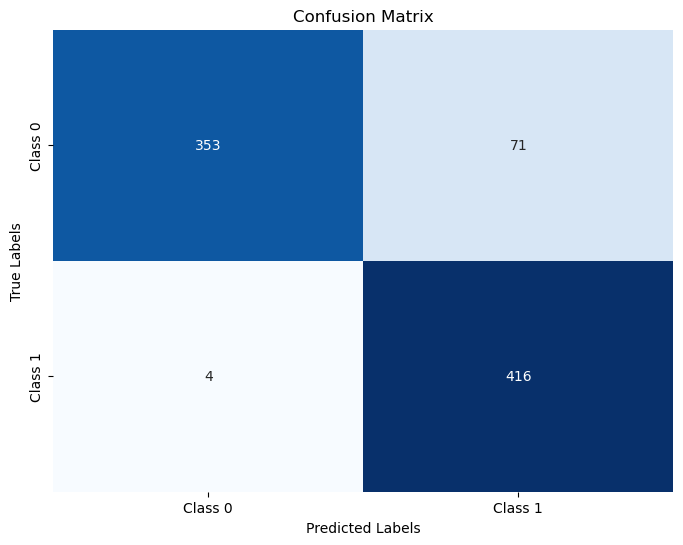

In [12]:
model_test(svm1, X_nt_adasyn, y_nt_adasyn)

Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.84      0.87       183
     Class 1       0.29      0.46      0.35        26

    accuracy                           0.79       209
   macro avg       0.60      0.65      0.61       209
weighted avg       0.84      0.79      0.81       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       153 |        30 |
+-----------+-----------+
|        14 |        12 |
+-----------+-----------+


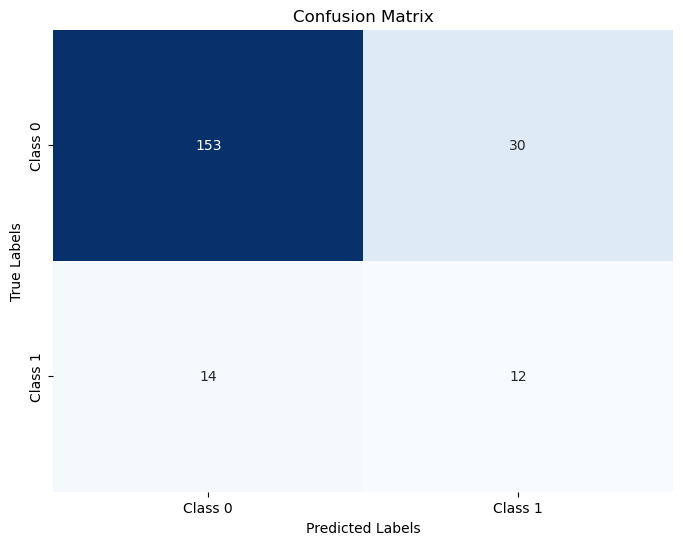

In [13]:
model_test(svm1)

In [14]:
# RECALL

Fitting 10 folds for each of 840 candidates, totalling 8400 fits
Time taken: 174.73476004600525 seconds
Best Hyperparameters: {'C': 0.0001, 'degree': 5, 'gamma': 0.9, 'kernel': 'poly'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.88      0.70      0.78       183
     Class 1       0.14      0.35      0.20        26

    accuracy                           0.66       209
   macro avg       0.51      0.53      0.49       209
weighted avg       0.79      0.66      0.71       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       129 |        54 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


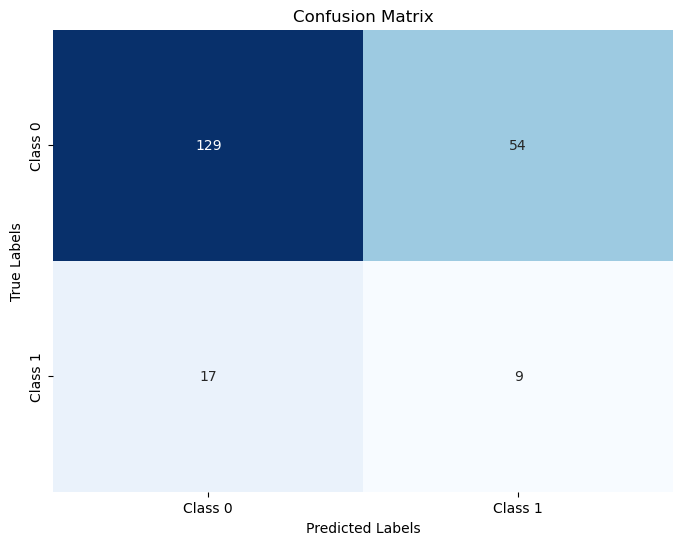

In [26]:
param_grid1 = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': [1e-3, 1e-2, 1e-1, 0.3, 0.5, 0.7, 0.9, 1, 'auto', 'scale'],
    'degree': [2, 3, 4, 5]
}
best_params1, best_svm1 = grid_searcher(param_grid1, svm1, 'recall')
model_test(best_svm1)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Time taken: 0.41312575340270996 seconds
Best Hyperparameters: {'kernel': 'poly'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.70      0.80       183
     Class 1       0.22      0.58      0.32        26

    accuracy                           0.69       209
   macro avg       0.57      0.64      0.56       209
weighted avg       0.83      0.69      0.74       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       129 |        54 |
+-----------+-----------+
|        11 |        15 |
+-----------+-----------+


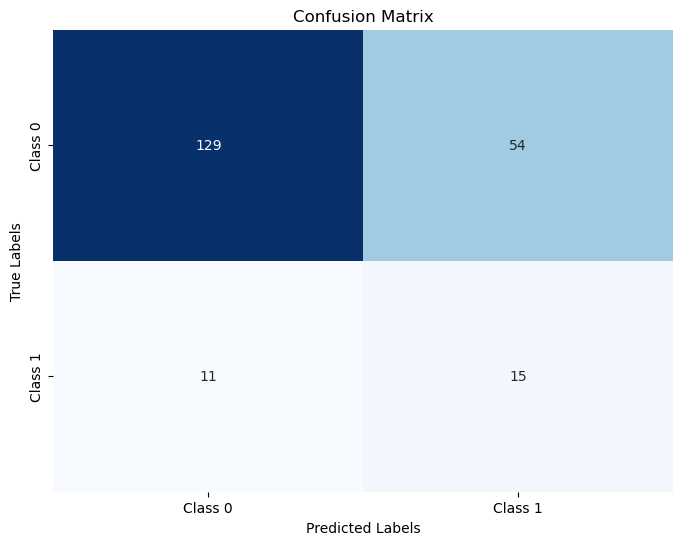

In [16]:
param_grid1a = {
    'kernel': ['linear', 'rbf', 'poly']
}
best_params1a, best_svm1a = grid_searcher(param_grid1a, svm1, 'recall')
model_test(best_svm1a)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Time taken: 0.6855087280273438 seconds
Best Hyperparameters: {'C': 100}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.78      0.84       183
     Class 1       0.25      0.50      0.33        26

    accuracy                           0.75       209
   macro avg       0.58      0.64      0.59       209
weighted avg       0.83      0.75      0.78       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       143 |        40 |
+-----------+-----------+
|        13 |        13 |
+-----------+-----------+


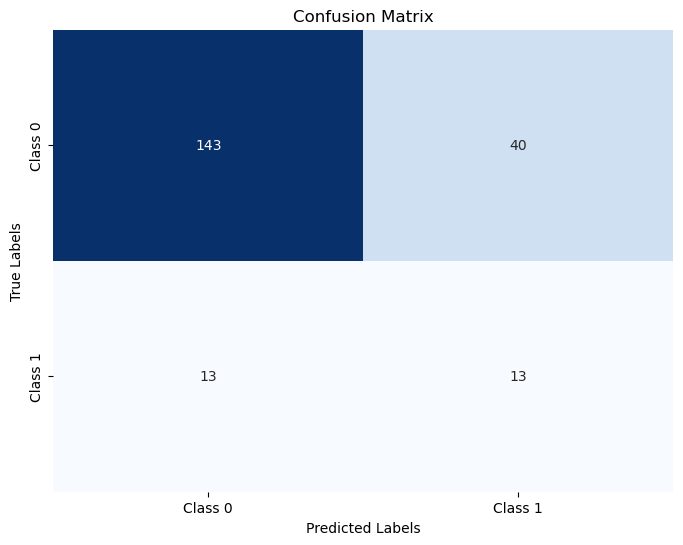

In [17]:
param_grid1b = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
}
best_params1b, best_svm1b = grid_searcher(param_grid1b, best_svm1a, 'recall')
model_test(best_svm1b)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time taken: 6.161751985549927 seconds
Best Hyperparameters: {'C': 35}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.79      0.85       183
     Class 1       0.22      0.42      0.29        26

    accuracy                           0.75       209
   macro avg       0.57      0.61      0.57       209
weighted avg       0.82      0.75      0.78       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       145 |        38 |
+-----------+-----------+
|        15 |        11 |
+-----------+-----------+


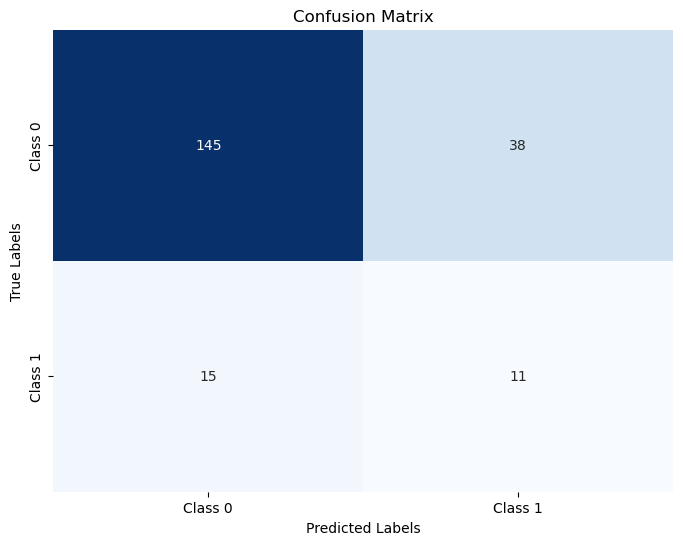

In [18]:
param_grid1c = {
    'C': list(np.arange(1, 101)),
}
best_params1c, best_svm1c = grid_searcher(param_grid1c, best_svm1b, 'recall')
model_test(best_svm1c)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Time taken: 0.4983787536621094 seconds
Best Hyperparameters: {'degree': 4}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.87      0.89       183
     Class 1       0.26      0.31      0.28        26

    accuracy                           0.80       209
   macro avg       0.58      0.59      0.58       209
weighted avg       0.82      0.80      0.81       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       160 |        23 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


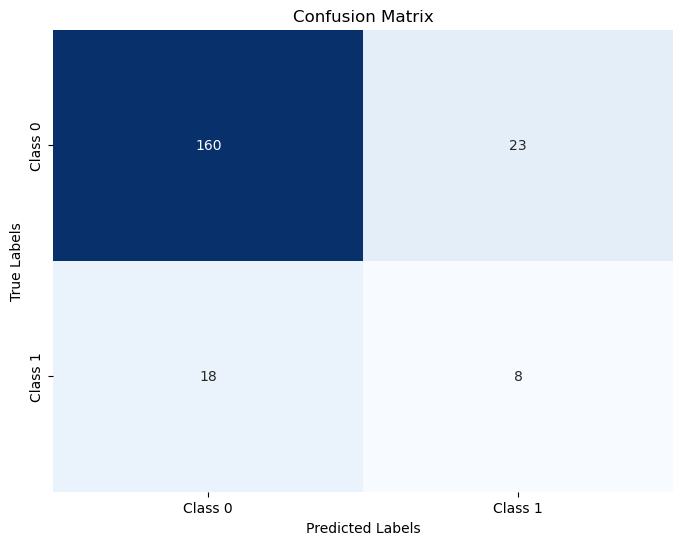

In [19]:
param_grid1d = {
    'degree': [2, 3, 4, 5],
}
best_params1d, best_svm1d = grid_searcher(param_grid1d, best_svm1b, 'recall')
model_test(best_svm1d)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 0.3524487018585205 seconds
Best Hyperparameters: {'kernel': 'rbf'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.84      0.87       183
     Class 1       0.29      0.46      0.35        26

    accuracy                           0.79       209
   macro avg       0.60      0.65      0.61       209
weighted avg       0.84      0.79      0.81       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       153 |        30 |
+-----------+-----------+
|        14 |        12 |
+-----------+-----------+


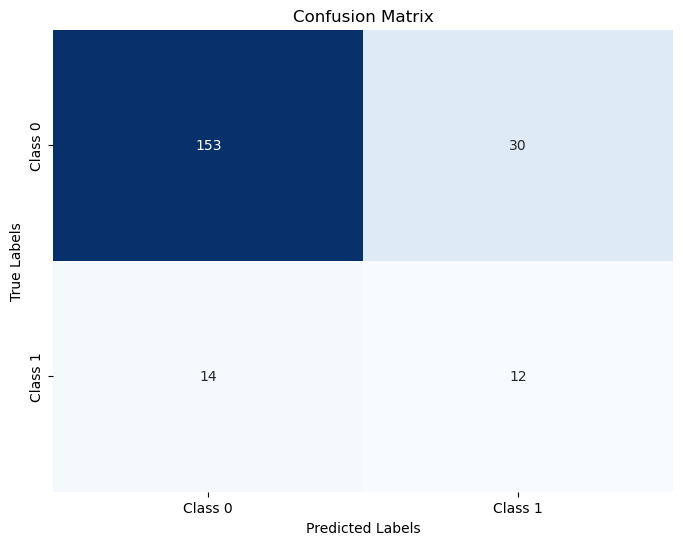

In [20]:
param_grid1e = {
    'kernel': ['linear', 'rbf'],
}
best_params1e, best_svm1e = grid_searcher(param_grid1e, svm1, 'recall')
model_test(best_svm1e)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Time taken: 0.7264485359191895 seconds
Best Hyperparameters: {'C': 10}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.88      0.89       183
     Class 1       0.24      0.27      0.25        26

    accuracy                           0.80       209
   macro avg       0.57      0.57      0.57       209
weighted avg       0.81      0.80      0.81       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       161 |        22 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


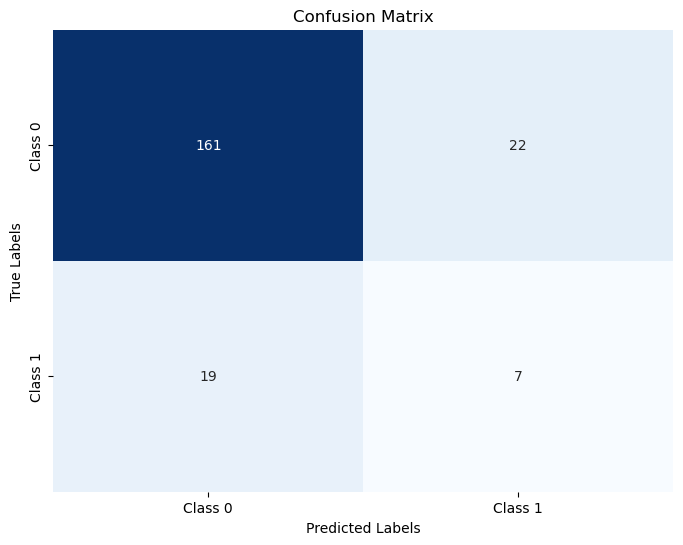

In [21]:
param_grid1f = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
}
best_params1f, best_svm1f = grid_searcher(param_grid1f, best_svm1e, 'recall')
model_test(best_svm1f)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time taken: 4.679968595504761 seconds
Best Hyperparameters: {'C': 9}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.90      0.90       183
     Class 1       0.27      0.27      0.27        26

    accuracy                           0.82       209
   macro avg       0.58      0.58      0.58       209
weighted avg       0.82      0.82      0.82       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       164 |        19 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


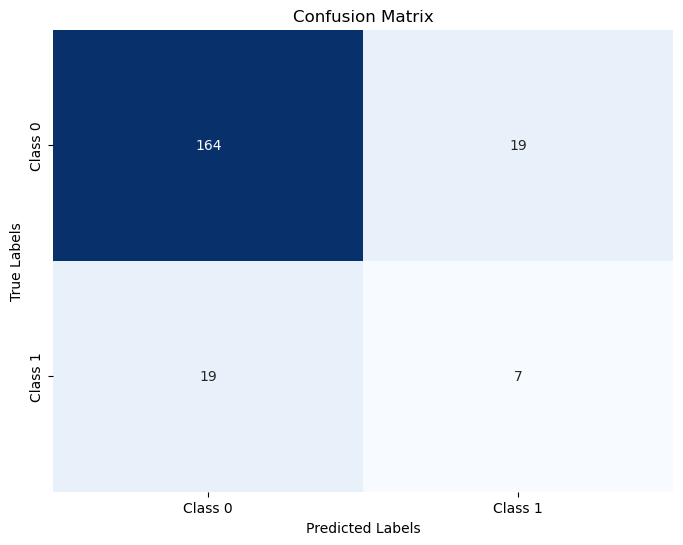

In [22]:
param_grid1g = {
    'C': list(np.arange(1, 101)),
}
best_params1g, best_svm1g = grid_searcher(param_grid1g, best_svm1f, 'recall')
model_test(best_svm1g)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 0.8746247291564941 seconds
Best Hyperparameters: {'gamma': 'auto'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.80      0.85       183
     Class 1       0.26      0.50      0.34        26

    accuracy                           0.76       209
   macro avg       0.59      0.65      0.60       209
weighted avg       0.84      0.76      0.79       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       146 |        37 |
+-----------+-----------+
|        13 |        13 |
+-----------+-----------+


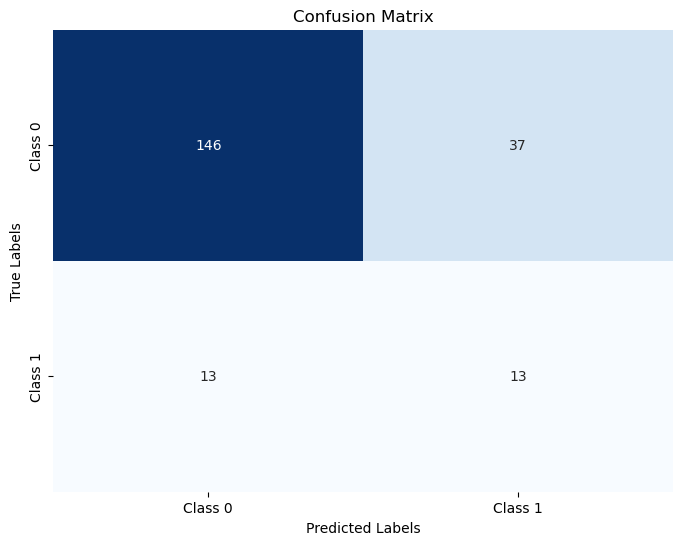

In [24]:
param_grid1c = {
    'gamma': [1e-3, 1e-2, 1e-1, 0.3, 0.5, 0.7, 0.9, 1, 'auto', 'scale'],
}
best_params1c, best_svm1c = grid_searcher(param_grid1c, best_svm1b, 'recall')
model_test(best_svm1c)

Fitting 10 folds for each of 400 candidates, totalling 4000 fits
Time taken: 43.39603877067566 seconds
Best Hyperparameters: {'C': 3, 'gamma': 0.1, 'kernel': 'rbf'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.93      0.91       183
     Class 1       0.28      0.19      0.23        26

    accuracy                           0.84       209
   macro avg       0.58      0.56      0.57       209
weighted avg       0.81      0.84      0.82       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       170 |        13 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


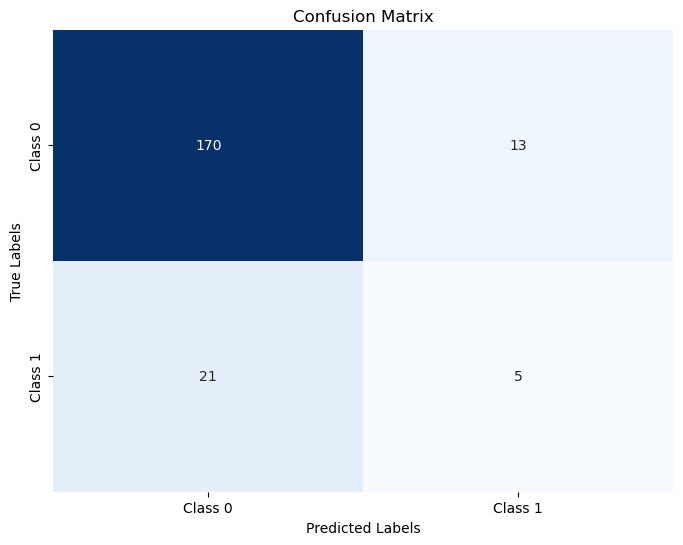

In [62]:
param_grid2 = {
    'kernel': ['linear', 'rbf'],
    # 'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'C': list(np.arange(1, 21)),
    'gamma': [1e-3, 1e-2, 1e-1, 0.3, 0.5, 0.7, 0.9, 1, 'auto', 'scale'],
}
best_params2, best_model2 = grid_searcher(param_grid2, svm1, 'recall')
model_test(best_model2)

In [25]:
# F1

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 0.312772274017334 seconds
Best Hyperparameters: {'C': 1000, 'kernel': 'rbf'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.92      0.91       183
     Class 1       0.35      0.31      0.33        26

    accuracy                           0.84       209
   macro avg       0.63      0.61      0.62       209
weighted avg       0.83      0.84      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       168 |        15 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


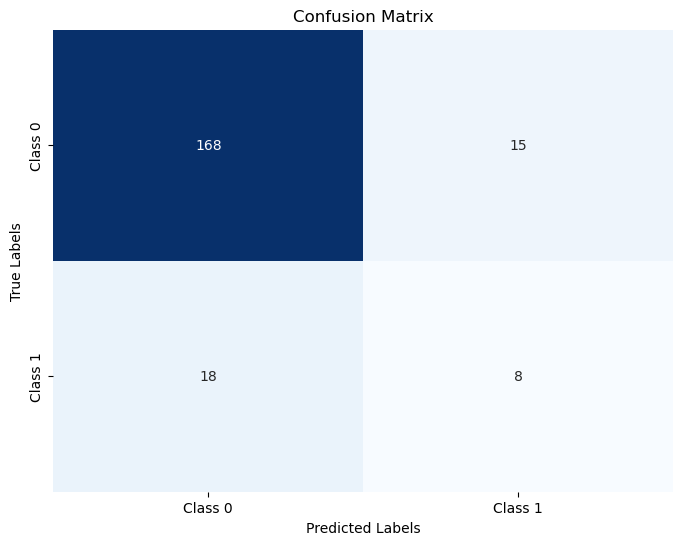

In [75]:
param_grid1 = {
    'C':  [1000],
    'kernel': ['rbf', 'poly'],
    # 'gamma': [1e-3, 1e-2, 1e-1, 0.3, 0.5, 0.7, 0.9, 1, 'auto', 'scale'],
    # 'degree': [2, 3, 4, 5]
}
best_params1, best_svm1 = grid_searcher(param_grid1, svm1, 'f1')
model_test(best_svm1)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Time taken: 7.729348421096802 seconds
Best Hyperparameters: {'gamma': 0.1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.95      0.92       183
     Class 1       0.33      0.19      0.24        26

    accuracy                           0.85       209
   macro avg       0.61      0.57      0.58       209
weighted avg       0.82      0.85      0.83       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       173 |        10 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


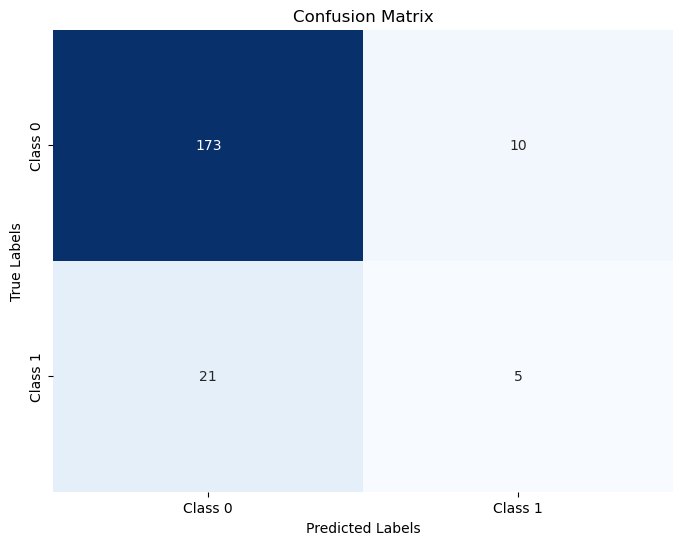

In [82]:
param_grid1a = {
    # 'C':  [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100], # 1000],
    # 'kernel': ['linear', 'poly', 'rbf'],
    'gamma': [1e-3, 1e-2, 1e-1, 1, 10, 'auto', 'scale'],
    # 'degree': [2, 3, 4, 5]
}
best_params1a, best_svm1a = grid_searcher(param_grid1a, best_svm1, 'jaccard')
model_test(best_svm1a)

Fitting 10 folds for each of 840 candidates, totalling 8400 fits
Time taken: 94.4466860294342 seconds
Best Hyperparameters: {'C': 100, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.94      0.91       183
     Class 1       0.31      0.19      0.24        26

    accuracy                           0.85       209
   macro avg       0.60      0.57      0.58       209
weighted avg       0.82      0.85      0.83       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       172 |        11 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


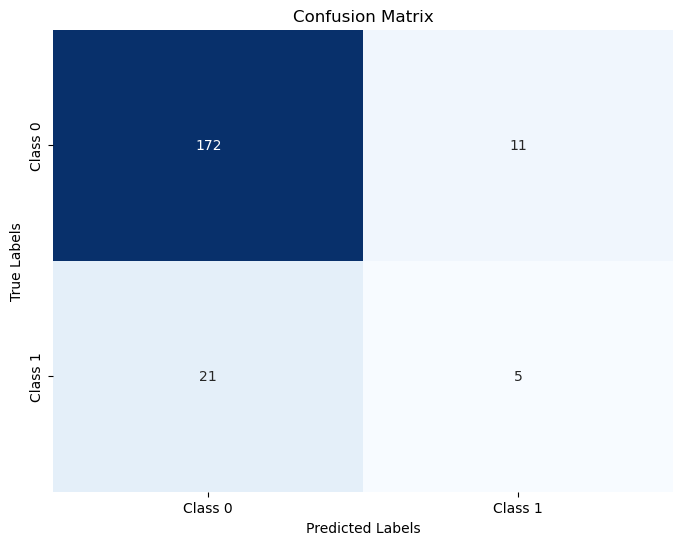

In [70]:
param_grid1 = {
    'C':  [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100], # 1000],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': [1e-3, 1e-2, 1e-1, 0.3, 0.5, 0.7, 0.9, 1, 'auto', 'scale'],
    'degree': [2, 3, 4, 5]
}
best_params1, best_svm1 = grid_searcher(param_grid1, svm1, 'f1')
model_test(best_svm1)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Time taken: 0.42484235763549805 seconds
Best Hyperparameters: {'kernel': 'rbf'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.84      0.87       183
     Class 1       0.29      0.46      0.35        26

    accuracy                           0.79       209
   macro avg       0.60      0.65      0.61       209
weighted avg       0.84      0.79      0.81       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       153 |        30 |
+-----------+-----------+
|        14 |        12 |
+-----------+-----------+


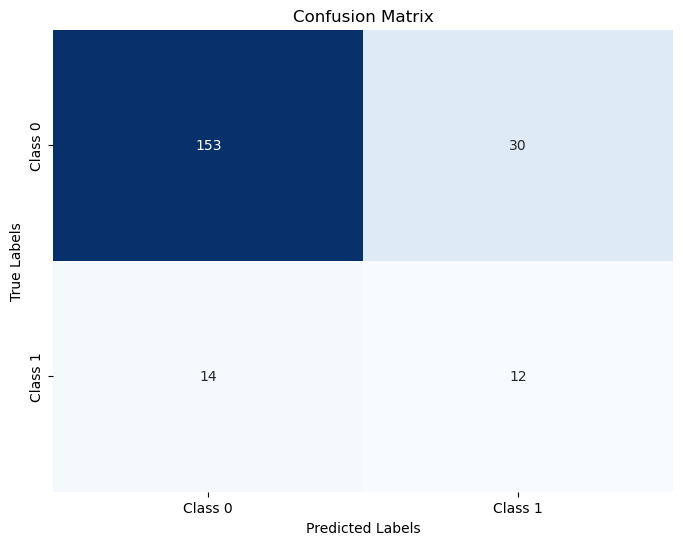

In [83]:
param_grid1a = {
    'kernel': ['linear', 'rbf', 'poly']
}
best_params1a, best_svm1a = grid_searcher(param_grid1a, svm1, 'f1')
model_test(best_svm1a)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Time taken: 0.6818933486938477 seconds
Best Hyperparameters: {'C': 100}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.92      0.91       183
     Class 1       0.29      0.23      0.26        26

    accuracy                           0.83       209
   macro avg       0.59      0.57      0.58       209
weighted avg       0.82      0.83      0.82       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       168 |        15 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


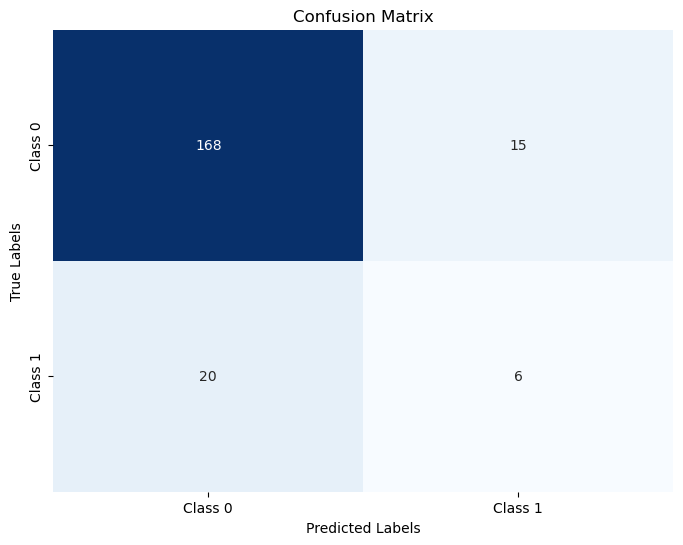

In [84]:
param_grid1b = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
}
best_params1b, best_svm1b = grid_searcher(param_grid1b, best_svm1a, 'f1')
model_test(best_svm1b)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time taken: 4.35360050201416 seconds
Best Hyperparameters: {'C': 30}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.90      0.90       183
     Class 1       0.27      0.27      0.27        26

    accuracy                           0.82       209
   macro avg       0.58      0.58      0.58       209
weighted avg       0.82      0.82      0.82       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       164 |        19 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


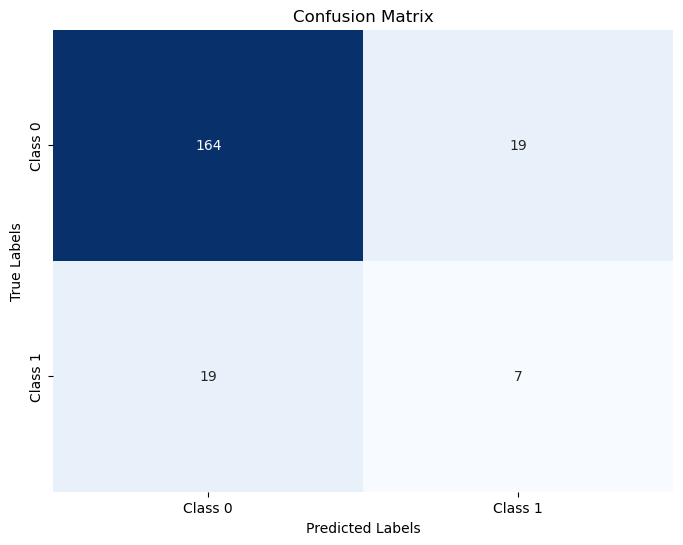

In [85]:
param_grid1c = {
    'C': list(np.arange(10, 1010, 10)),
}
best_params1c, best_svm1c = grid_searcher(param_grid1c, best_svm1b, 'f1')
model_test(best_svm1c)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 0.895641565322876 seconds
Best Hyperparameters: {'gamma': 0.1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.94      0.91       183
     Class 1       0.31      0.19      0.24        26

    accuracy                           0.85       209
   macro avg       0.60      0.57      0.58       209
weighted avg       0.82      0.85      0.83       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       172 |        11 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


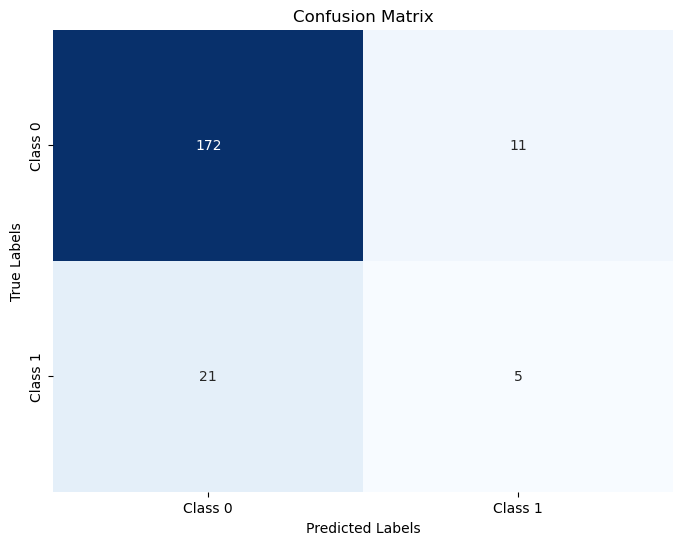

In [86]:
param_grid1d = {
    'gamma': [1e-3, 1e-2, 1e-1, 0.3, 0.5, 0.7, 0.9, 1, 'auto', 'scale'],
}
best_params1d, best_svm1d = grid_searcher(param_grid1d, best_svm1b, 'f1')
model_test(best_svm1d)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 0.9635043144226074 seconds
Best Hyperparameters: {'gamma': 0.1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.94      0.91       183
     Class 1       0.31      0.19      0.24        26

    accuracy                           0.85       209
   macro avg       0.60      0.57      0.58       209
weighted avg       0.82      0.85      0.83       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       172 |        11 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


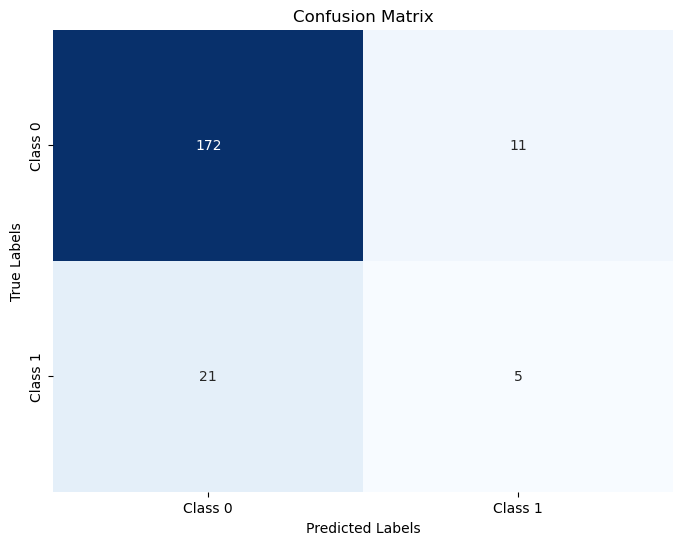

In [87]:
param_grid1d = {
    'gamma': [1e-3, 1e-2, 1e-1, 0.3, 0.5, 0.7, 0.9, 1, 'auto', 'scale'],
}
best_params1d, best_svm1d = grid_searcher(param_grid1d, best_svm1c, 'f1')
model_test(best_svm1d)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 0.31425929069519043 seconds
Best Hyperparameters: {'kernel': 'poly'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.70      0.80       183
     Class 1       0.22      0.58      0.32        26

    accuracy                           0.69       209
   macro avg       0.57      0.64      0.56       209
weighted avg       0.83      0.69      0.74       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       129 |        54 |
+-----------+-----------+
|        11 |        15 |
+-----------+-----------+


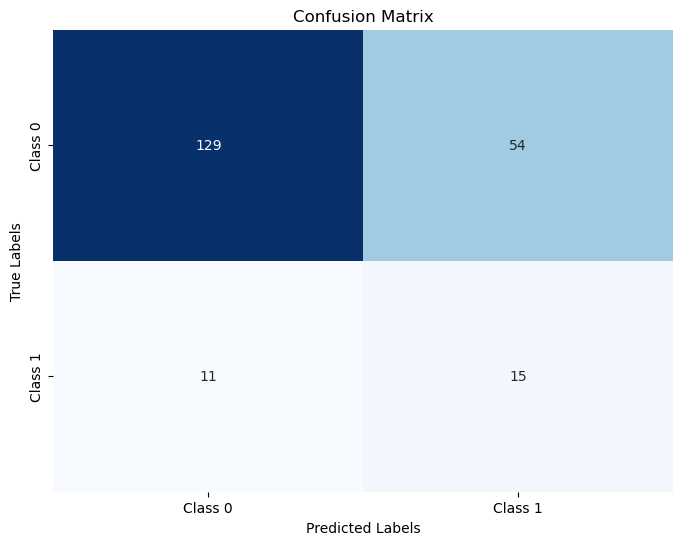

In [88]:
param_grid1e = {
    'kernel': ['linear', 'poly'],
}
best_params1e, best_svm1e = grid_searcher(param_grid1e, svm1, 'f1')
model_test(best_svm1e)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Time taken: 0.5819833278656006 seconds
Best Hyperparameters: {'C': 10}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.82      0.86       183
     Class 1       0.25      0.42      0.31        26

    accuracy                           0.77       209
   macro avg       0.58      0.62      0.59       209
weighted avg       0.83      0.77      0.79       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       150 |        33 |
+-----------+-----------+
|        15 |        11 |
+-----------+-----------+


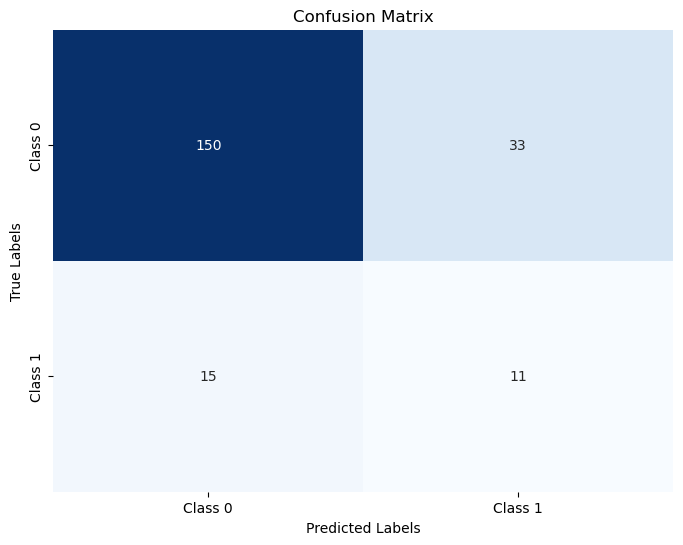

In [89]:
param_grid1f = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
}
best_params1f, best_svm1f = grid_searcher(param_grid1f, best_svm1e, 'f1')
model_test(best_svm1f)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time taken: 5.120547294616699 seconds
Best Hyperparameters: {'C': 9.9}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.81      0.86       183
     Class 1       0.24      0.42      0.31        26

    accuracy                           0.77       209
   macro avg       0.58      0.62      0.58       209
weighted avg       0.83      0.77      0.79       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       149 |        34 |
+-----------+-----------+
|        15 |        11 |
+-----------+-----------+


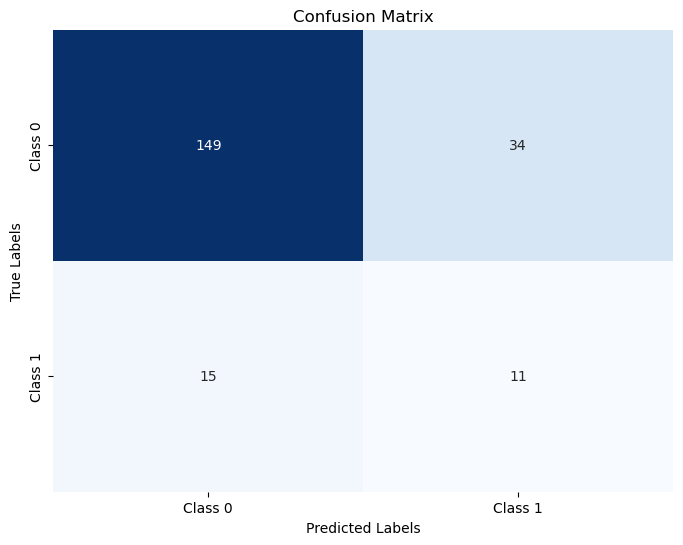

In [93]:
param_grid1g = {
    'C': list(np.arange(0.1, 10.1, 0.1)),
}
best_params1g, best_svm1g = grid_searcher(param_grid1g, best_svm1f, 'f1')
model_test(best_svm1g)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Time taken: 0.43195629119873047 seconds
Best Hyperparameters: {'degree': 4}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.85      0.88       183
     Class 1       0.25      0.35      0.29        26

    accuracy                           0.79       209
   macro avg       0.58      0.60      0.58       209
weighted avg       0.82      0.79      0.80       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       156 |        27 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


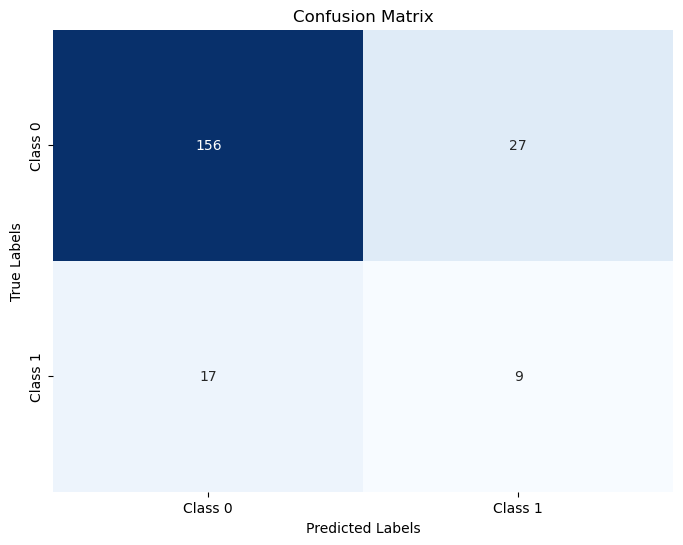

In [96]:
param_grid1h = {
    'degree': [2, 3, 4, 5],
}
best_params1h, best_svm1h = grid_searcher(param_grid1h, best_svm1f, 'f1')
model_test(best_svm1h)

In [39]:
# MATTHEWS_CORRCOEF

Fitting 10 folds for each of 840 candidates, totalling 8400 fits
Time taken: 164.94504523277283 seconds
Best Hyperparameters: {'C': 100, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.94      0.91       183
     Class 1       0.31      0.19      0.24        26

    accuracy                           0.85       209
   macro avg       0.60      0.57      0.58       209
weighted avg       0.82      0.85      0.83       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       172 |        11 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


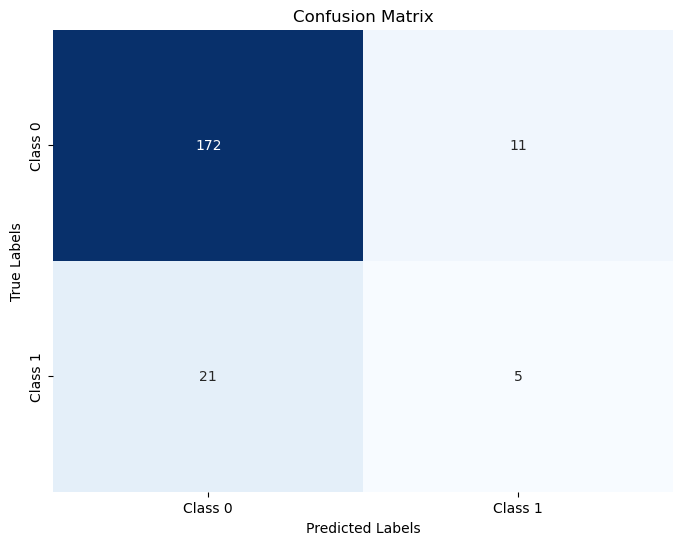

In [97]:
param_grid1 = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': [1e-3, 1e-2, 1e-1, 0.3, 0.5, 0.7, 0.9, 1, 'auto', 'scale'],
    'degree': [2, 3, 4, 5]
}
best_params1, best_svm1 = grid_searcher(param_grid1, svm1, 'matthews_corrcoef')
model_test(best_svm1)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Time taken: 0.3786735534667969 seconds
Best Hyperparameters: {'kernel': 'rbf'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.84      0.87       183
     Class 1       0.29      0.46      0.35        26

    accuracy                           0.79       209
   macro avg       0.60      0.65      0.61       209
weighted avg       0.84      0.79      0.81       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       153 |        30 |
+-----------+-----------+
|        14 |        12 |
+-----------+-----------+


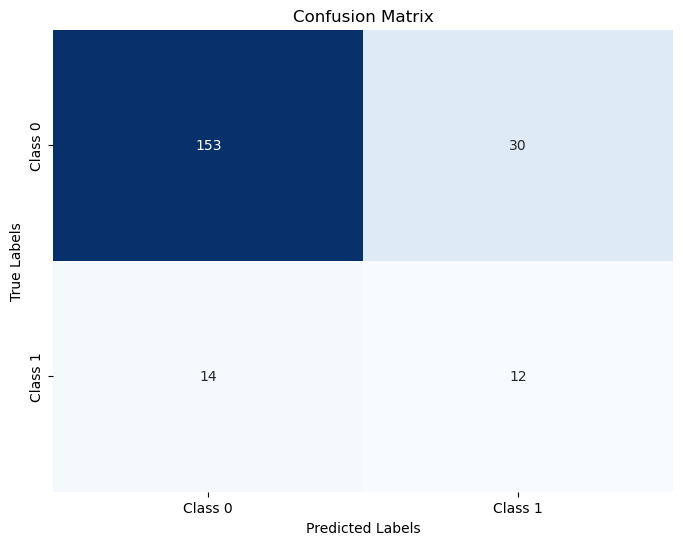

In [98]:
param_grid1a = {
    'kernel': ['linear', 'rbf', 'poly']
}
best_params1a, best_svm1a = grid_searcher(param_grid1a, svm1, 'matthews_corrcoef')
model_test(best_svm1a)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Time taken: 0.6575877666473389 seconds
Best Hyperparameters: {'C': 100}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.92      0.91       183
     Class 1       0.29      0.23      0.26        26

    accuracy                           0.83       209
   macro avg       0.59      0.57      0.58       209
weighted avg       0.82      0.83      0.82       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       168 |        15 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


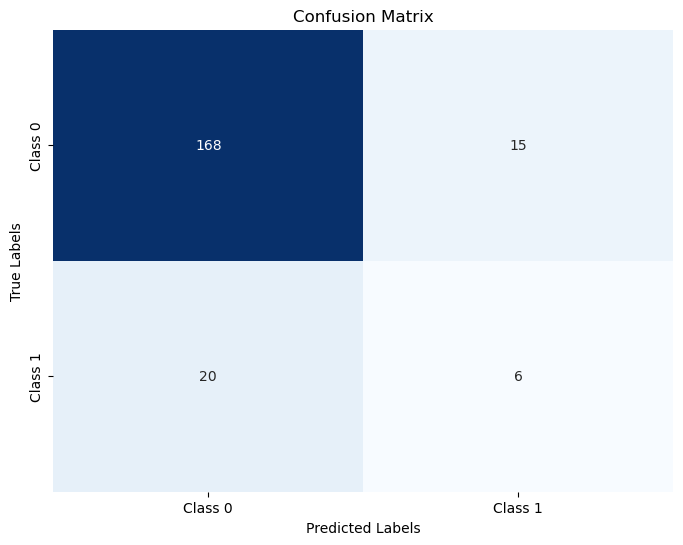

In [99]:
param_grid1b = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
}
best_params1b, best_svm1b = grid_searcher(param_grid1b, best_svm1a, 'matthews_corrcoef')
model_test(best_svm1b)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time taken: 4.602444887161255 seconds
Best Hyperparameters: {'C': 30}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.90      0.90       183
     Class 1       0.27      0.27      0.27        26

    accuracy                           0.82       209
   macro avg       0.58      0.58      0.58       209
weighted avg       0.82      0.82      0.82       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       164 |        19 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


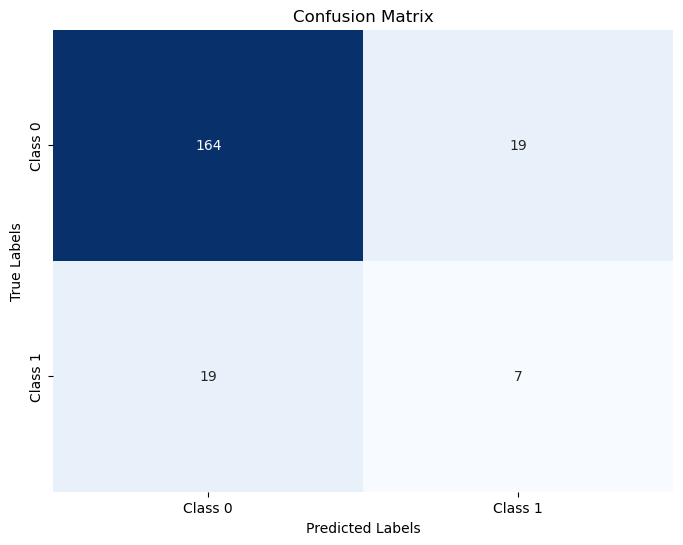

In [102]:
param_grid1c = {
    'C': list(np.arange(1, 101)),
    # 'C': list(np.arange(10, 1010, 10)),
}
best_params1c, best_svm1c = grid_searcher(param_grid1c, best_svm1b, 'matthews_corrcoef')
model_test(best_svm1c)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 0.9188764095306396 seconds
Best Hyperparameters: {'gamma': 0.1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.94      0.91       183
     Class 1       0.31      0.19      0.24        26

    accuracy                           0.85       209
   macro avg       0.60      0.57      0.58       209
weighted avg       0.82      0.85      0.83       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       172 |        11 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


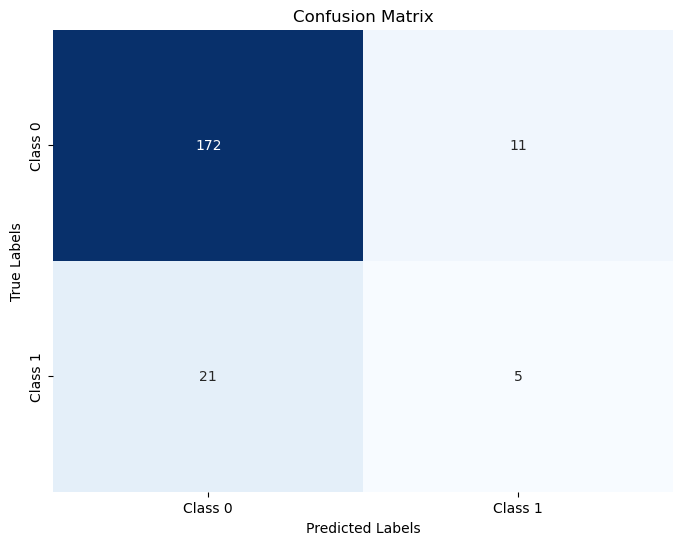

In [103]:
param_grid1d = {
    'gamma': [1e-3, 1e-2, 1e-1, 0.3, 0.5, 0.7, 0.9, 1, 'auto', 'scale'],
}
best_params1d, best_svm1d = grid_searcher(param_grid1d, best_svm1c, 'matthews_corrcoef')
model_test(best_svm1d)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 1.0060482025146484 seconds
Best Hyperparameters: {'gamma': 0.3}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.97      0.93       183
     Class 1       0.44      0.15      0.23        26

    accuracy                           0.87       209
   macro avg       0.67      0.56      0.58       209
weighted avg       0.83      0.87      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       178 |         5 |
+-----------+-----------+
|        22 |         4 |
+-----------+-----------+


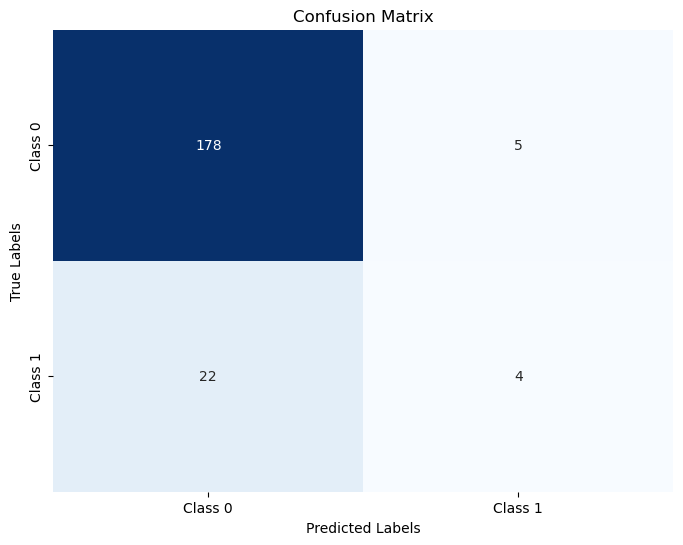

In [104]:
param_grid1d = {
    'gamma': [1e-3, 1e-2, 1e-1, 0.3, 0.5, 0.7, 0.9, 1, 'auto', 'scale'],
}
best_params1d, best_svm1d = grid_searcher(param_grid1d, best_svm1a, 'matthews_corrcoef')
model_test(best_svm1d)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 0.30152082443237305 seconds
Best Hyperparameters: {'kernel': 'poly'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.70      0.80       183
     Class 1       0.22      0.58      0.32        26

    accuracy                           0.69       209
   macro avg       0.57      0.64      0.56       209
weighted avg       0.83      0.69      0.74       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       129 |        54 |
+-----------+-----------+
|        11 |        15 |
+-----------+-----------+


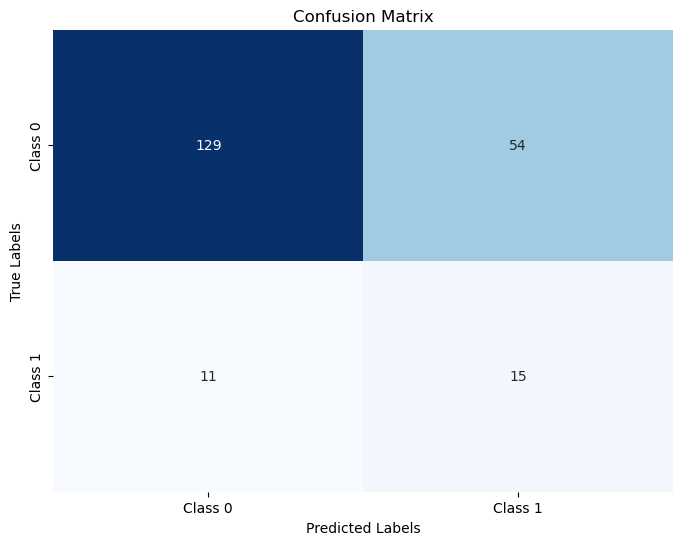

In [105]:
param_grid1e = {
    'kernel': ['linear', 'poly']
}
best_params1e, best_svm1e = grid_searcher(param_grid1e, svm1, 'matthews_corrcoef')
model_test(best_svm1e)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Time taken: 0.7005033493041992 seconds
Best Hyperparameters: {'C': 100}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.78      0.84       183
     Class 1       0.25      0.50      0.33        26

    accuracy                           0.75       209
   macro avg       0.58      0.64      0.59       209
weighted avg       0.83      0.75      0.78       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       143 |        40 |
+-----------+-----------+
|        13 |        13 |
+-----------+-----------+


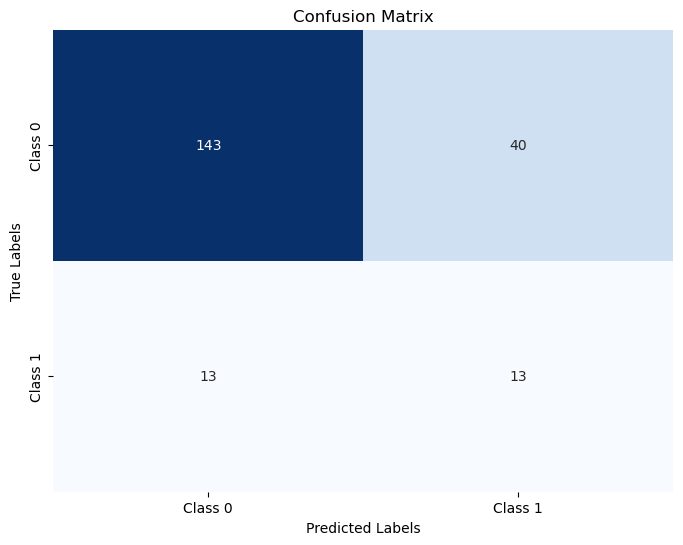

In [106]:
param_grid1f = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
}
best_params1f, best_svm1f = grid_searcher(param_grid1f, best_svm1e, 'matthews_corrcoef')
model_test(best_svm1f)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time taken: 6.346177577972412 seconds
Best Hyperparameters: {'C': 21}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.80      0.85       183
     Class 1       0.23      0.42      0.30        26

    accuracy                           0.75       209
   macro avg       0.57      0.61      0.57       209
weighted avg       0.82      0.75      0.78       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       146 |        37 |
+-----------+-----------+
|        15 |        11 |
+-----------+-----------+


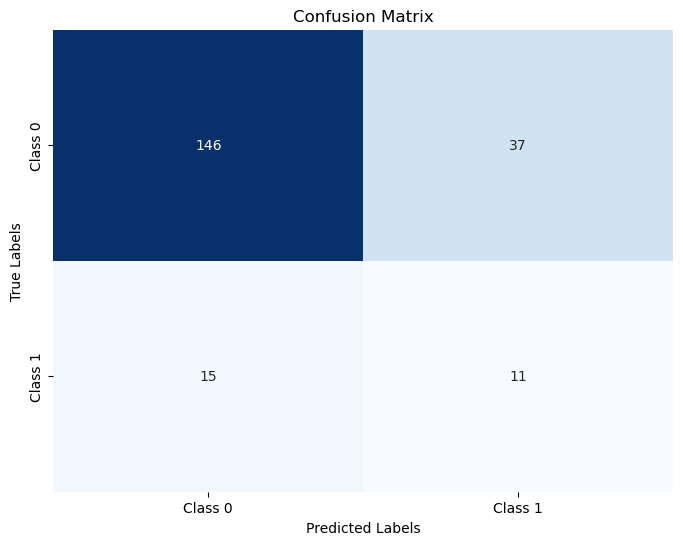

In [107]:
param_grid1g = {
    'C': list(np.arange(1, 1001, 10)),
}
best_params1g, best_svm1g = grid_searcher(param_grid1g, best_svm1f, 'matthews_corrcoef')
model_test(best_svm1g)

In [110]:
svm1.C

1.0